In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,root_mean_squared_error,mean_absolute_error
from datetime import datetime,timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

In [163]:
# This is the path to the files downloaded from the M5 kaggle competition: https://www.kaggle.com/competitions/m5-forecasting-accuracy
files_path = '../Docs/m5-forecasting-accuracy'

# Load the data (modify the file path as needed)
sales_data = pd.read_csv(f'{files_path}/sales_train_validation.csv')

In [164]:
# Filter rows where 'id' column contains 'FOODS'
filtered_sales_data = sales_data[sales_data['id'].str.contains('FOODS')]
filtered_sales_data = filtered_sales_data[sales_data['state_id'].str.contains('CA')]

np.random.seed(19) # We fix the seed to aways have the same sample selection

# Sample 10 unique store IDs
unique_item_ids = filtered_sales_data['item_id'].unique()
unique_item_ids = np.random.choice(unique_item_ids, 10, replace=False)

filtered_sales_data = filtered_sales_data[filtered_sales_data['item_id'].isin(unique_item_ids)]

sales_data = filtered_sales_data.copy()
sales_data.reset_index(drop=True, inplace=True)

del filtered_sales_data

C:\Users\engca\AppData\Local\Temp\ipykernel_11764\2956920971.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_sales_data = filtered_sales_data[sales_data['state_id'].str.contains('CA')]


In [165]:
sales_data.head()

id      item_id  dept_id cat_id store_id state_id  \
0  FOODS_1_054_CA_1_validation  FOODS_1_054  FOODS_1  FOODS     CA_1       CA   
1  FOODS_1_175_CA_1_validation  FOODS_1_175  FOODS_1  FOODS     CA_1       CA   
2  FOODS_2_119_CA_1_validation  FOODS_2_119  FOODS_2  FOODS     CA_1       CA   
3  FOODS_2_215_CA_1_validation  FOODS_2_215  FOODS_2  FOODS     CA_1       CA   
4  FOODS_2_305_CA_1_validation  FOODS_2_305  FOODS_2  FOODS     CA_1       CA   

   d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  d_13  d_14  \
0    0    1    0   11    1    1    1    1    1     1     0     2     4     0   
1    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
2    1    4    2    2    1    2    2    2    2     0     2     0     1     1   
3    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
4    0    0    0    0    0    1    0    0    0     0     0     0     0     0   

   d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  d_25  d_26  \
0     5     3     1     3     0     0     0     0     5     4     2     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     2     5     1     1     3     0     6     0     0     0     0     2   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     1     0     1     0     0     0     0     0     0     0     0   

   d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  d_37  d_38  \
0     2     4     6     1     7     5     2     0     0     2     1     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     4     2     0     2     6     2     0     0     6     1     1     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     1     0     0     0     0     0     0     0     2     0     0     0   

   d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  d_49  d_50  \
0     3     0     0     9     7     2     3     0     1     1     4     3   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     2     1     0     0     0     1     0     0     2     0   

   d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  d_61  d_62  \
0     1     0     0     4     1     3     2     2     2     2     0     2   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     1     0     0     0     0     1     1     0     0     0     0   

   d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  d_73  d_74  \
0     0     2     3     1     0     2     4     5     2     2     1     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     1     0     0     0     0     0     0     1     0     0     0   

   d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  d_85  d_86  \
0     5     1     3     8     8     2     0     0     3     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     1     0     0     0   

   d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  d_97  d_98  \
0     0     0     0     0     2     1     5     2     1     1     3     3   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0  

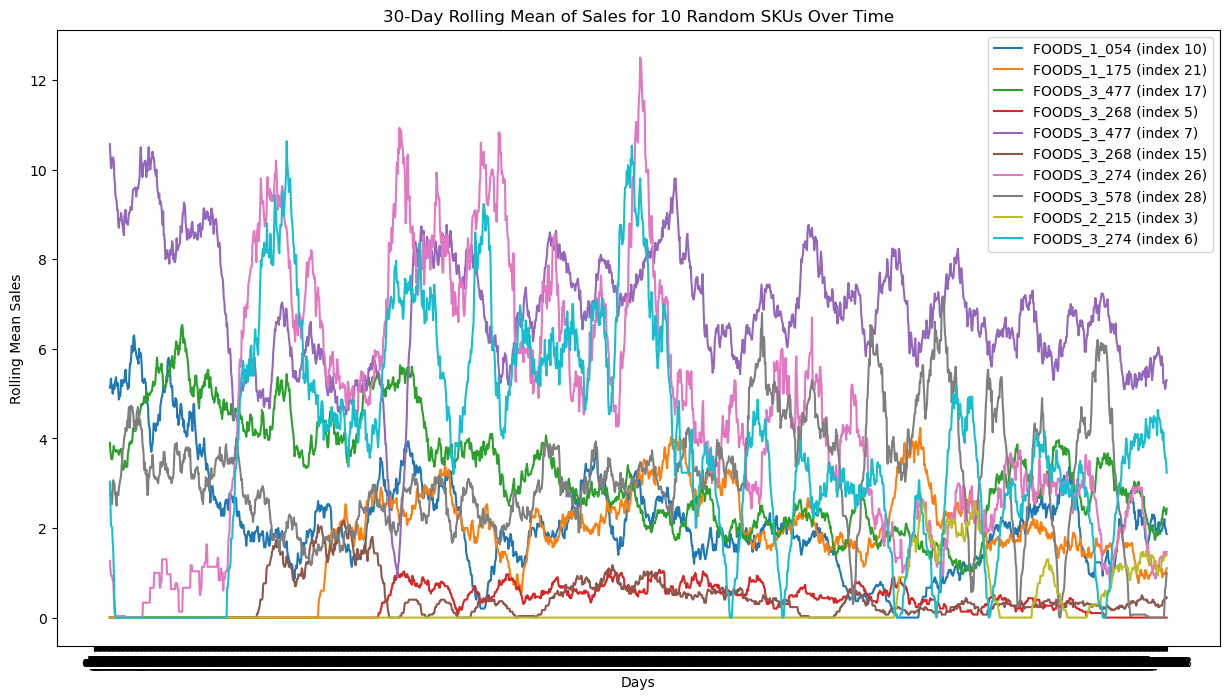

In [166]:
# Assuming 'sales_data' is already loaded and contains columns like 'd_1', 'd_2', etc., representing daily sales

# Filter out non-sales columns
sales_only = sales_data.filter(regex='^d_', axis=1)

# Select 10 random SKUs
selected_skus_indices = np.random.choice(sales_data.index, 10, replace=False)
selected_skus_data = sales_only.loc[selected_skus_indices]

# Define the window for rolling mean
rolling_window = 30  # for example, a 30-day rolling window

# Plotting
plt.figure(figsize=(15, 8))
for i, sku_index in enumerate(selected_skus_indices):
    sku_id = sales_data.loc[sku_index, 'item_id']
    rolling_mean = selected_skus_data.loc[sku_index, :].rolling(window=rolling_window).mean()
    plt.plot(selected_skus_data.columns, rolling_mean, label=f'{sku_id} (index {sku_index})')

plt.title(f'30-Day Rolling Mean of Sales for 10 Random SKUs Over Time')
plt.xlabel('Days')
plt.ylabel('Rolling Mean Sales')
plt.legend()
plt.show()

del selected_skus_data
del selected_skus_indices
del sales_only

In [167]:
# Melt the sales data to long format
sales_long = pd.melt(sales_data,
                     id_vars=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                     var_name='day',
                     value_name='sale_qty')

# Extracting day numbers and converting to float first to handle NaN values
sales_long['day'] = sales_long['day'].str.extract('(\d+)').astype(float)

# You can check if there are any NaN values and handle them as needed
nan_count = sales_long['day'].isna().sum()
if nan_count > 0:
    print(f"There are {nan_count} NaN values in the 'day' column")

# Assuming we can drop NaN values (or you can handle them differently)
sales_long = sales_long.dropna(subset=['day'])

# Now safely convert to int
sales_long['day'] = sales_long['day'].astype(int)

sales_long.reset_index(drop=True, inplace=True)

del sales_data

There are 40 NaN values in the 'day' column


<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
C:\Users\engca\AppData\Local\Temp\ipykernel_11764\492567134.py:8: SyntaxWarning: invalid escape sequence '\d'
  sales_long['day'] = sales_long['day'].str.extract('(\d+)').astype(float)


In [168]:
calendar_data = pd.read_csv(f'{files_path}/calendar.csv')

In [169]:
# Convert 'date' in the calendar DataFrame to a sequential day number
calendar_data['day'] = pd.to_datetime(calendar_data['date']).sub(pd.to_datetime(calendar_data['date'].iloc[0])).dt.days + 1

# Preview the calendar data
calendar_data.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  day  
0          NaN          NaN          NaN        0        0        0    1  
1          NaN          NaN          NaN        0        0        0    2  
2          NaN          NaN          NaN        0        0        0    3  
3          NaN          NaN          NaN        1        1        0    4  
4          NaN          NaN          NaN        1        0        1    5

In [170]:
# Merge the sales_long and calendar DataFrames
merged_data_calendar = pd.merge(sales_long, calendar_data, on='day', how='left')
del calendar_data
del sales_long

In [171]:
price_data = pd.read_csv(f'{files_path}/sell_prices.csv')

In [172]:
# Merge sales and price data
merged_data = pd.merge(merged_data_calendar, price_data, on=['item_id', 'store_id', 'wm_yr_wk'], how='left')
del price_data
del merged_data_calendar

In [173]:
# Count the number of unique item_ids in the filtered_data DataFrame
unique_item_id_count = merged_data['item_id'].nunique()

# Print the count
print(f"Number of unique item_ids: {unique_item_id_count}")
del unique_item_id_count

Number of unique item_ids: 10


In [174]:
# Identify the item_id with all NaN prices
item_ids_with_all_nan_prices = merged_data.groupby('item_id')['sell_price'].apply(lambda x: x.isna().all())

# Filtering out the item_ids to exclude (those with all NaN dates)
item_ids_to_exclude = item_ids_with_all_nan_prices[item_ids_with_all_nan_prices].index.tolist()

# Now filter out these item_ids from the merged_data
filtered_data = merged_data[~merged_data['item_id'].isin(item_ids_to_exclude)]

# Preview the filtered data
filtered_data.head()

item_id  dept_id cat_id store_id state_id  day sale_qty        date  \
0  FOODS_1_054  FOODS_1  FOODS     CA_1       CA    1        0  2011-01-29   
1  FOODS_1_175  FOODS_1  FOODS     CA_1       CA    1        0  2011-01-29   
2  FOODS_2_119  FOODS_2  FOODS     CA_1       CA    1        1  2011-01-29   
3  FOODS_2_215  FOODS_2  FOODS     CA_1       CA    1        0  2011-01-29   
4  FOODS_2_305  FOODS_2  FOODS     CA_1       CA    1        0  2011-01-29   

   wm_yr_wk   weekday  wday  month  year    d event_name_1 event_type_1  \
0     11101  Saturday     1      1  2011  d_1          NaN          NaN   
1     11101  Saturday     1      1  2011  d_1          NaN          NaN   
2     11101  Saturday     1      1  2011  d_1          NaN          NaN   
3     11101  Saturday     1      1  2011  d_1          NaN          NaN   
4     11101  Saturday     1      1  2011  d_1          NaN          NaN   

  event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  sell_price  
0          NaN          NaN        0        0        0        1.68  
1          NaN          NaN        0        0        0         NaN  
2          NaN          NaN        0        0        0        2.98  
3          NaN          NaN        0        0        0         NaN  
4          NaN          NaN        0        0        0       10.48

In [175]:
# Count the number of unique item_ids in the filtered_data DataFrame
unique_item_id_count = filtered_data['item_id'].nunique()

# Print the count
print(f"Number of unique item_ids: {unique_item_id_count}")

Number of unique item_ids: 10


In [176]:
# Ensure the data is sorted by date
filtered_data.sort_values(by='date', inplace=True)

# Create two Series: one filled forward and one filled backward
forward_filled = filtered_data.groupby('item_id')['sell_price'].fillna(method='ffill')
backward_filled = filtered_data.groupby('item_id')['sell_price'].fillna(method='bfill')

# Combine the results, preferring the forward fill
combined_fill = forward_filled.combine_first(backward_filled)

# Assign the combined result back to the sell_price column
filtered_data['sell_price'] = combined_fill

C:\Users\engca\AppData\Local\Temp\ipykernel_11764\2717069662.py:5: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  forward_filled = filtered_data.groupby('item_id')['sell_price'].fillna(method='ffill')
C:\Users\engca\AppData\Local\Temp\ipykernel_11764\2717069662.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forward_filled = filtered_data.groupby('item_id')['sell_price'].fillna(method='ffill')
C:\Users\engca\AppData\Local\Temp\ipykernel_11764\2717069662.py:6: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  backward_filled = filtered

In [177]:
# Check if there are any remaining NaN values in sell_price
remaining_nan = filtered_data['sell_price'].isna().sum()
print(f"Remaining NaN values in sell_price: {remaining_nan}")

Remaining NaN values in sell_price: 0


In [178]:
del combined_fill
del backward_filled
del forward_filled
del item_ids_to_exclude
del item_ids_with_all_nan_prices

In [179]:
categorical_columns = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
                       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']

for col in categorical_columns:
    filtered_data[col] = filtered_data[col].astype('category').cat.codes

In [180]:
filtered_data['year'] = filtered_data['year'] - filtered_data['year'].min()
filtered_data['weekday'] = filtered_data['weekday'].astype('category').cat.codes
data = filtered_data

In [181]:
window_sizes_lag = [1, 2, 3, 4, 5, 6, 7, 14, 30, 60]

for window in window_sizes_lag:
    data[f'lag_{window}'] = data.groupby(['item_id', 'store_id'])['sale_qty'].shift(window)

window_sizes_rolling = [2, 3, 4, 7, 14, 30, 60]

for window in window_sizes_rolling:
    rolling_mean = data.groupby(['item_id', 'store_id'])['sale_qty'].transform(lambda x: x.rolling(window=window).mean())
    rolling_sum = data.groupby(['item_id', 'store_id'])['sale_qty'].transform(lambda x: x.rolling(window=window).sum())

    data[f'rolling_mean_{window}'] = rolling_mean
    data[f'rolling_sum_{window}'] = rolling_sum

In [182]:
# Handling NaN values
data.dropna(inplace=True)
data.drop(['d'],axis = 1,inplace=True)

In [183]:
# Set option to display all columns
pd.set_option('display.max_columns', None)
data[(data['item_id'] == 1) & (data['store_id'] == 1)].head(5)

item_id  dept_id  cat_id  store_id  state_id  day sale_qty        date  \
2411        1        0       0         1         0   61        0  2011-03-30   
2451        1        0       0         1         0   62        0  2011-03-31   
2491        1        0       0         1         0   63        0  2011-04-01   
2531        1        0       0         1         0   64        0  2011-04-02   
2571        1        0       0         1         0   65        0  2011-04-03   

      wm_yr_wk  weekday  wday  month  year  event_name_1  event_type_1  \
2411     11109        6     5      3     0            -1            -1   
2451     11109        4     6      3     0            -1            -1   
2491     11109        0     7      4     0            -1            -1   
2531     11110        2     1      4     0            -1            -1   
2571     11110        3     2      4     0            -1            -1   

      event_name_2  event_type_2  snap_CA  snap_TX  snap_WI  sell_price lag_1  \
2411            -1            -1        0        0        0        2.88     0   
2451            -1            -1        0        0        0        2.88     0   
2491            -1            -1        1        1        0        2.88     0   
2531            -1            -1        1        0        1        2.88     0   
2571            -1            -1        1        1        1        2.88     0   

     lag_2 lag_3 lag_4 lag_5 lag_6 lag_7 lag_14 lag_30 lag_60  rolling_mean_2  \
2411     0     0     0     0     0     0      0      0      0             0.0   
2451     0     0     0     0     0     0      0      0      0             0.0   
2491     0     0     0     0     0     0      0      0      0             0.0   
2531     0     0     0     0     0     0      0      0      0             0.0   
2571     0     0     0     0     0     0      0      0      0             0.0   

      rolling_sum_2  rolling_mean_3  rolling_sum_3  rolling_mean_4  \
2411            0.0             0.0            0.0             0.0   
2451            0.0             0.0            0.0             0.0   
2491            0.0             0.0            0.0             0.0   
2531            0.0             0.0            0.0             0.0   
2571            0.0             0.0            0.0             0.0   

      rolling_sum_4  rolling_mean_7  rolling_sum_7  rolling_mean_14  \
2411            0.0             0.0            0.0              0.0   
2451            0.0             0.0            0.0              0.0   
2491            0.0             0.0            0.0              0.0   
2531            0.0             0.0            0.0              0.0   
2571            0.0             0.0            0.0              0.0   

      rolling_sum_14  rolling_mean_30  rolling_sum_30  rolling_mean_60  \
2411             0.0              0.0             0.0              0.0   
2451             0.0              0.0             0.0              0.0   
2491             0.0              0.0             0.0              0.0   
2531             0.0              0.0             0.0              0.0   
2571             0.0              0.0             0.0              0.0   

      rolling_sum_60  
2411             0.0  
2451             0.0  
2491             0.0  
2531             0.0  
2571             0.0

In [184]:
# Ensure the data is sorted by date
filtered_data.sort_values(by='date', inplace=True)

# Create two Series: one filled forward and one filled backward
forward_filled = filtered_data.groupby('item_id')['sell_price'].fillna(method='ffill')
backward_filled = filtered_data.groupby('item_id')['sell_price'].fillna(method='bfill')

# Combine the results, preferring the forward fill
combined_fill = forward_filled.combine_first(backward_filled)

# Assign the combined result back to the sell_price column
filtered_data['sell_price'] = combined_fill

C:\Users\engca\AppData\Local\Temp\ipykernel_11764\2717069662.py:5: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  forward_filled = filtered_data.groupby('item_id')['sell_price'].fillna(method='ffill')
C:\Users\engca\AppData\Local\Temp\ipykernel_11764\2717069662.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forward_filled = filtered_data.groupby('item_id')['sell_price'].fillna(method='ffill')
C:\Users\engca\AppData\Local\Temp\ipykernel_11764\2717069662.py:6: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  backward_filled = filtered

In [185]:
data.sell_price.isna().sum().sum()

0

In [186]:
# Assuming 'data' is your DataFrame

# Create the target variable (next day's sale_qty)
data['target'] = data.groupby(['item_id', 'store_id'])['sale_qty'].shift(-1)

# Drop rows with NaN in target due to the shift operation
data.dropna(subset=['target'], inplace=True)

# Splitting the data into features and target
X = data.drop(['target', 'wm_yr_wk', 'date'], axis=1)
y = data['target']

# Lists to store individual DataFrames for concatenation
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# Split index for each series
split_ratio = 0.8

for (item, store), group in data.groupby(['item_id', 'store_id']):
    split_index = int(len(group) * split_ratio)

    X_train_list.append(group.iloc[:split_index].drop(['target', 'wm_yr_wk', 'date'], axis=1))
    X_test_list.append(group.iloc[split_index:].drop(['target', 'wm_yr_wk', 'date'], axis=1))
    y_train_list.append(group.iloc[:split_index]['target'])
    y_test_list.append(group.iloc[split_index:]['target'])

# Concatenate all individual DataFrames
X_train = pd.concat(X_train_list)
X_test = pd.concat(X_test_list)
y_train = pd.concat(y_train_list)
y_test = pd.concat(y_test_list)

In [187]:
# List of continuous columns to scale
non_continuous_columns = categorical_columns + ['d', 'date','wm_yr_wk']

continuous_columns = X_train.columns.difference(non_continuous_columns)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the continuous variables of the training data
scaler.fit(X_train[continuous_columns])

# Transform the continuous variables in both training and test sets
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_columns] = scaler.transform(X_train[continuous_columns])
X_test_scaled[continuous_columns] = scaler.transform(X_test[continuous_columns])

In [188]:
# Convert features to numeric type
numeric_features = ['sale_qty', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_14', 'lag_30', 'lag_60']
X_train[numeric_features] = X_train[numeric_features].apply(pd.to_numeric, errors='coerce')
X_test[numeric_features] = X_test[numeric_features].apply(pd.to_numeric, errors='coerce')

# After converting, you may need to drop NaN values that were introduced during conversion
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

# Convert the target variable to numeric type
y_train = pd.to_numeric(y_train, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

# After converting, you may need to drop NaN values that were introduced during conversion
y_train.dropna(inplace=True)
y_test.dropna(inplace=True)

# Inicio da Atividade

## Preparação dos dados para análises auto regressivas e média movel

Sendo assim, ao final temos:\
X train e test = Contèm características da série temporal (qual o dia da semana, se é ou não feriado, etc) e a série em si\
Y train e test = A série temporal do dia seguinte (será utilizada para modelos que não utilizam a autoregressão)\
Sendo assim:
- Para modelos clássicos de análise de time-series (SARIMA(s,d,q)(S,D,Q)) &rarr; Xtrain e test
- Para modelos como gradient boosting e redes neurais utilizaremos tanto X quanto Y

In [189]:
X_train.head()

item_id  dept_id  cat_id  store_id  state_id  day  sale_qty  weekday  \
2400        0        0       0         0         0   61         0        6   
2440        0        0       0         0         0   62         2        4   
2480        0        0       0         0         0   63         0        0   
2520        0        0       0         0         0   64         2        2   
2560        0        0       0         0         0   65         3        3   

      wday  month  year  event_name_1  event_type_1  event_name_2  \
2400     5      3     0            -1            -1            -1   
2440     6      3     0            -1            -1            -1   
2480     7      4     0            -1            -1            -1   
2520     1      4     0            -1            -1            -1   
2560     2      4     0            -1            -1            -1   

      event_type_2  snap_CA  snap_TX  snap_WI  sell_price  lag_1  lag_2  \
2400            -1        0        0        0        1.68      2      2   
2440            -1        0        0        0        1.68      0      2   
2480            -1        1        1        0        1.68      2      0   
2520            -1        1        0        1        1.68      0      2   
2560            -1        1        1        1        1.68      2      0   

      lag_3  lag_4  lag_5  lag_6  lag_7  lag_14  lag_30  lag_60  \
2400      2      2      3      1      4       1       7       0   
2440      2      2      2      3      1       1       5       1   
2480      2      2      2      2      3       4       2       0   
2520      0      2      2      2      2       3       0      11   
2560      2      0      2      2      2       1       0       1   

      rolling_mean_2  rolling_sum_2  rolling_mean_3  rolling_sum_3  \
2400             1.0            2.0        1.333333            4.0   
2440             1.0            2.0        1.333333            4.0   
2480             1.0            2.0        0.666667            2.0   
2520             1.0            2.0        1.333333            4.0   
2560             2.5            5.0        1.666667            5.0   

      rolling_mean_4  rolling_sum_4  rolling_mean_7  rolling_sum_7  \
2400            1.50            6.0        1.714286           12.0   
2440            1.50            6.0        1.857143           13.0   
2480            1.00            4.0        1.428571           10.0   
2520            1.00            4.0        1.428571           10.0   
2560            1.75            7.0        1.571429           11.0   

      rolling_mean_14  rolling_sum_14  rolling_mean_30  rolling_sum_30  \
2400         1.785714            25.0         2.000000            60.0   
2440         1.857143            26.0         1.900000            57.0   
2480         1.571429            22.0         1.833333            55.0   
2520         1.500000            21.0         1.900000            57.0   
2560         1.642857            23.0         2.000000            60.0   

      rolling_mean_60  rolling_sum_60  
2400         2.116667           127.0  
2440         2.133333           128.0  
2480         2.133333           128.0  
2520         1.983333           119.0  
2560         2.016667           121.0

In [190]:
dados_analise_tempo = X_train[['item_id','store_id','day','sale_qty']]

In [191]:
dados_analise_tempo.sort_values(by='day',inplace=True)

C:\Users\engca\AppData\Local\Temp\ipykernel_11764\1843553744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise_tempo.sort_values(by='day',inplace=True)


Visualizar as séries temporais

In [192]:
dados_analise_tempo.item_id.unique()

array([0, 2, 7, 1, 8, 9, 4, 5, 3, 6], dtype=int8)

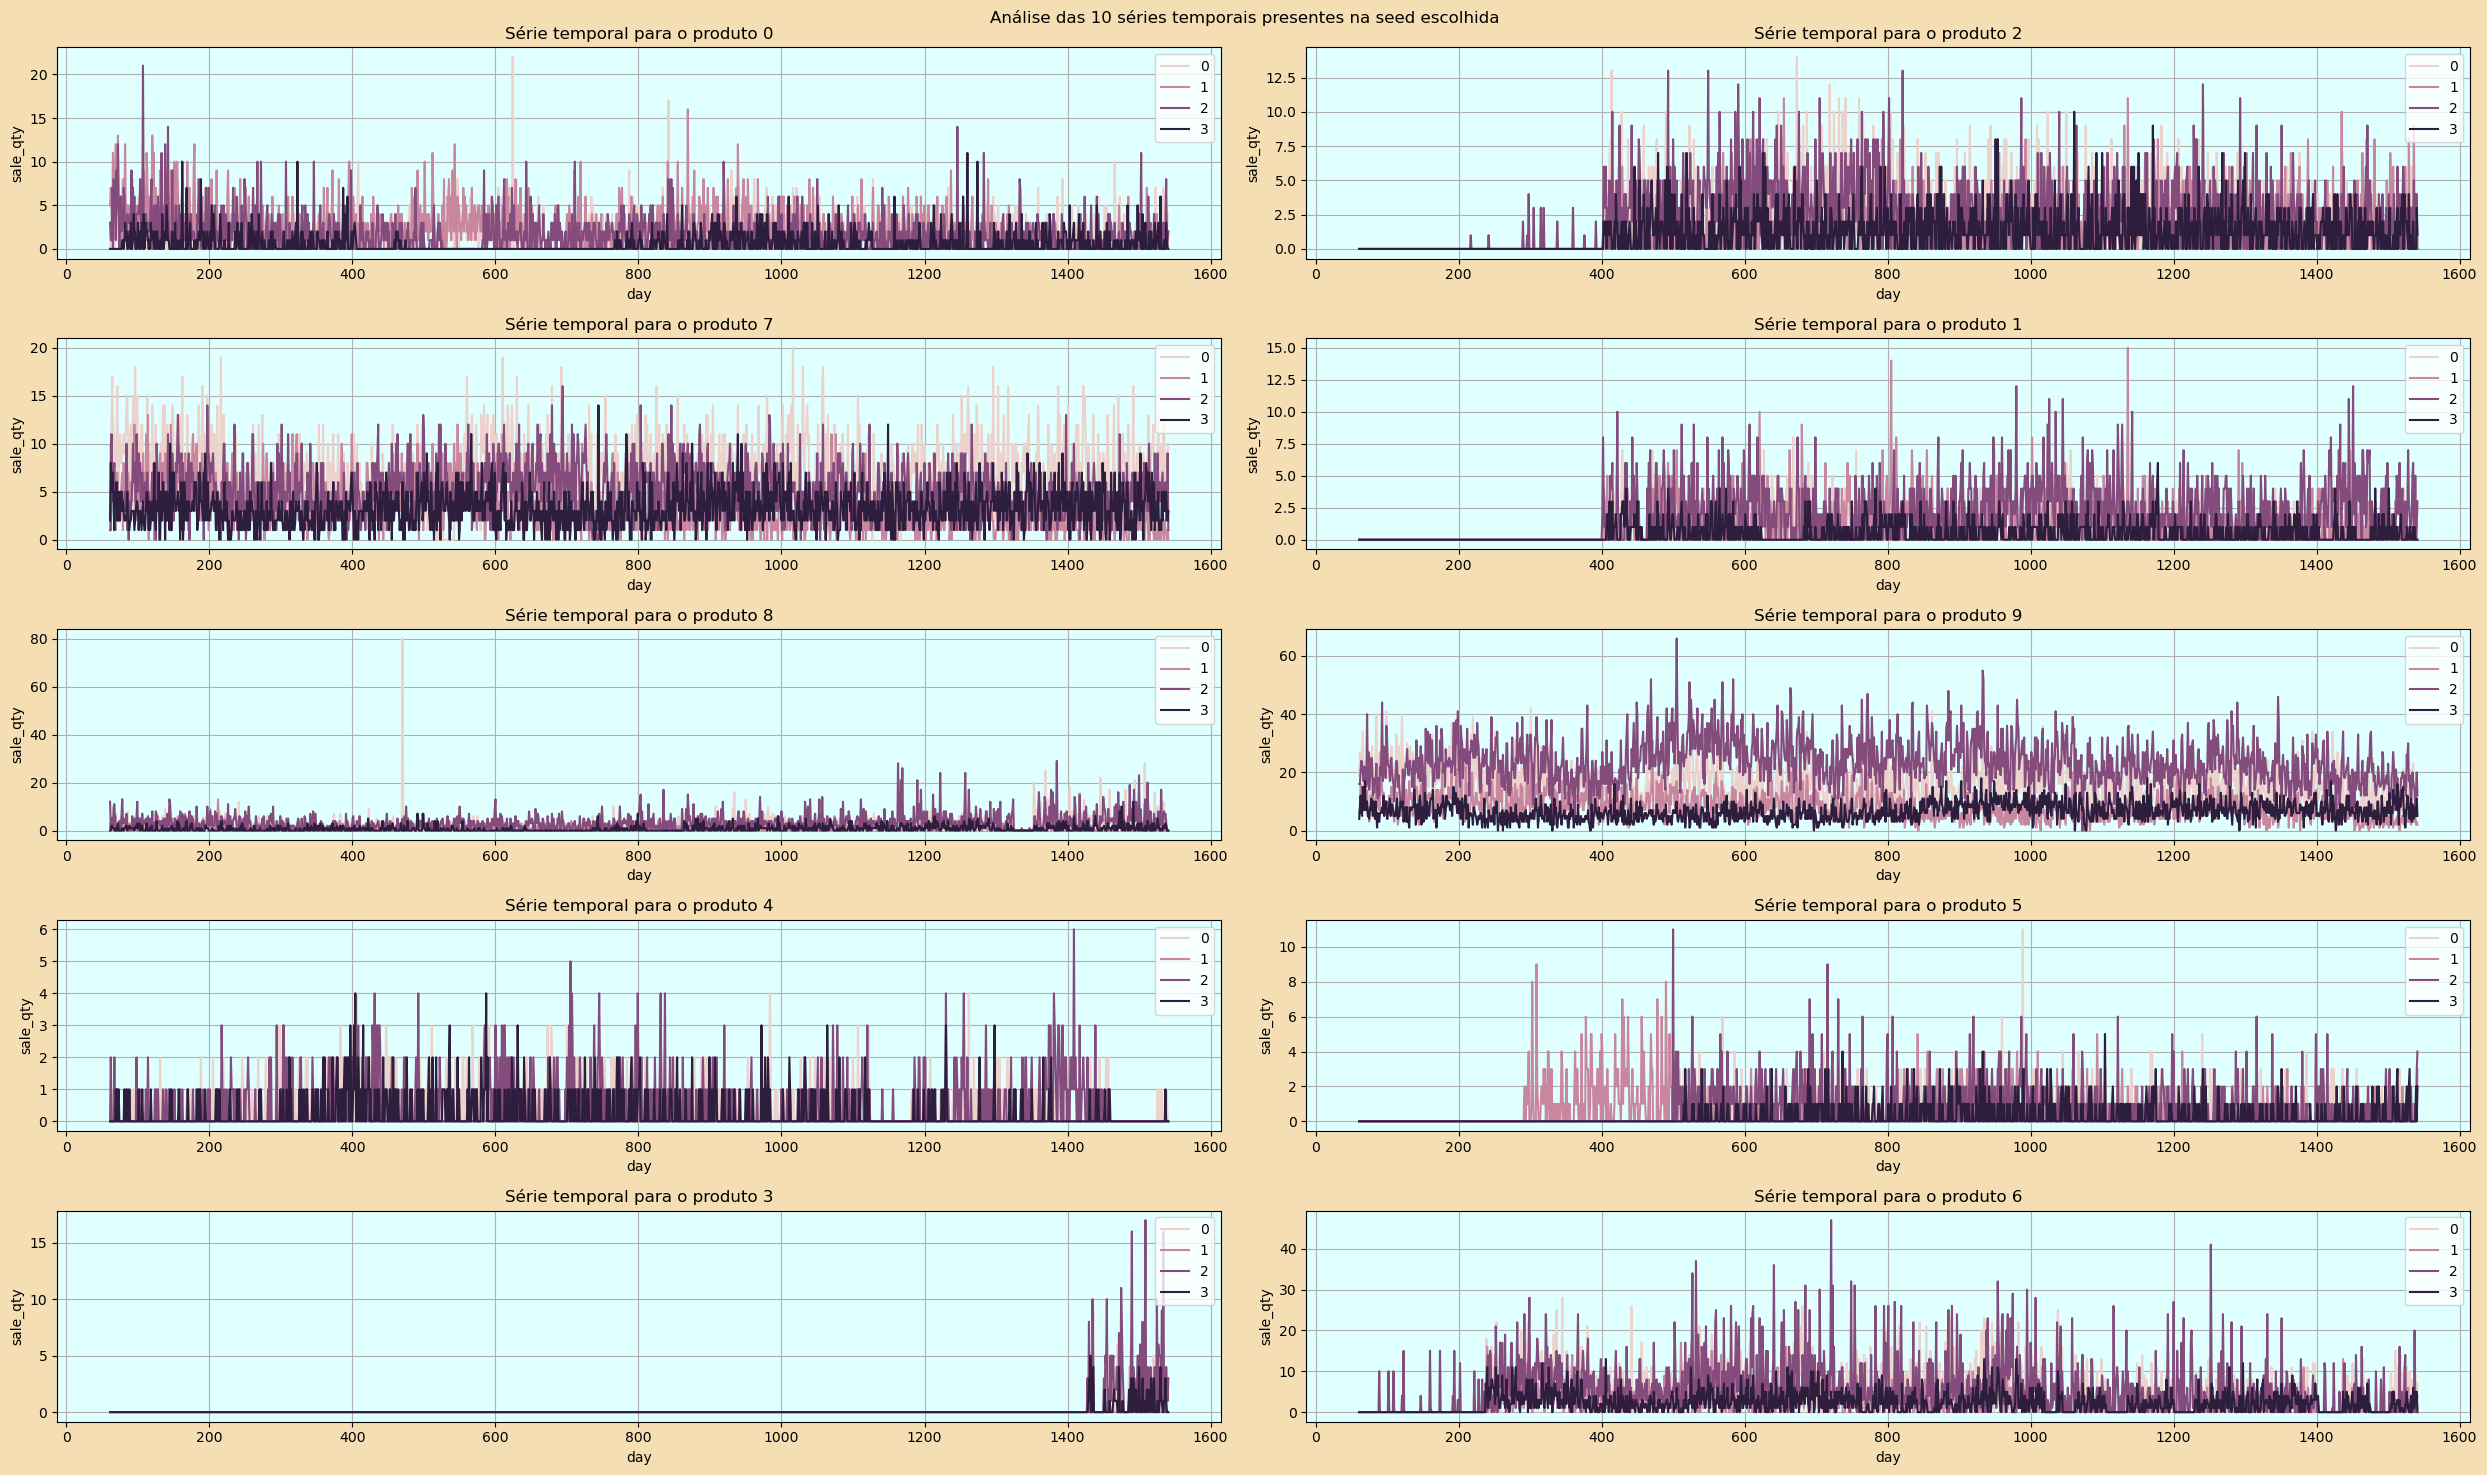

In [193]:
fig, axes = plt.subplots(5,2,figsize=(25,15),facecolor='wheat')
axes_flatten = axes.flatten()
produtos = dados_analise_tempo.item_id.unique().tolist()
for i,val in enumerate(produtos):
    sns.lineplot(data=dados_analise_tempo[dados_analise_tempo.item_id == val],
                x='day',
                y='sale_qty',
                hue='store_id',
                ax=axes_flatten[i])
    axes_flatten[i].set_facecolor('lightcyan')
    axes_flatten[i].grid()
    axes_flatten[i].legend(bbox_to_anchor=(1,1),loc='upper right',fancybox=True)
    axes_flatten[i].set_title(f'Série temporal para o produto {val}')
plt.suptitle('Análise das 10 séries temporais presentes na seed escolhida')
plt.tight_layout()
plt.show()

Podemos observar que, para as séries temporais contidas no estudo, as que contém as melhores séries a serem estudadas são:
- Produto 9, loja 2
- Produto 7, loja 2

In [194]:
serie1 = dados_analise_tempo[(dados_analise_tempo.item_id == 7)
                            &(dados_analise_tempo.store_id == 2)]
serie4 = dados_analise_tempo[(dados_analise_tempo.item_id == 9)
                            &(dados_analise_tempo.store_id == 2)]

In [195]:
serie1.head()

item_id  store_id  day  sale_qty
2427        7         2   61         1
2467        7         2   62         1
2507        7         2   63        11
2547        7         2   64         4
2587        7         2   65         5

Para realizar a decomposição, precisamos de um dataframe com index de data

In [196]:
df_serie1 = pd.DataFrame(serie1.sale_qty.values, index=pd.date_range("2021-01-01", periods=len(serie1.sale_qty.values)), columns=['Value'])

In [197]:
df_serie4 = pd.DataFrame(serie4.sale_qty.values, index=pd.date_range("2021-01-01", periods=len(serie4.sale_qty.values)), columns=['Value'])

## Decomposição da série temporal

Realize a decomposição da série temporal na 4 componentes apresentadas em aula:
1. Iremos plotar as séries para realizar uma análise gráfica ( e o adfuller para testar por estacionariedae)
2. Diferenciar para achar a tendência
3. Análisar a média móvel para encontrar a sazonalidade
4. Observar o ruído restante
5. Plotar o PACF e o ACF para análises mais complexas

In [198]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

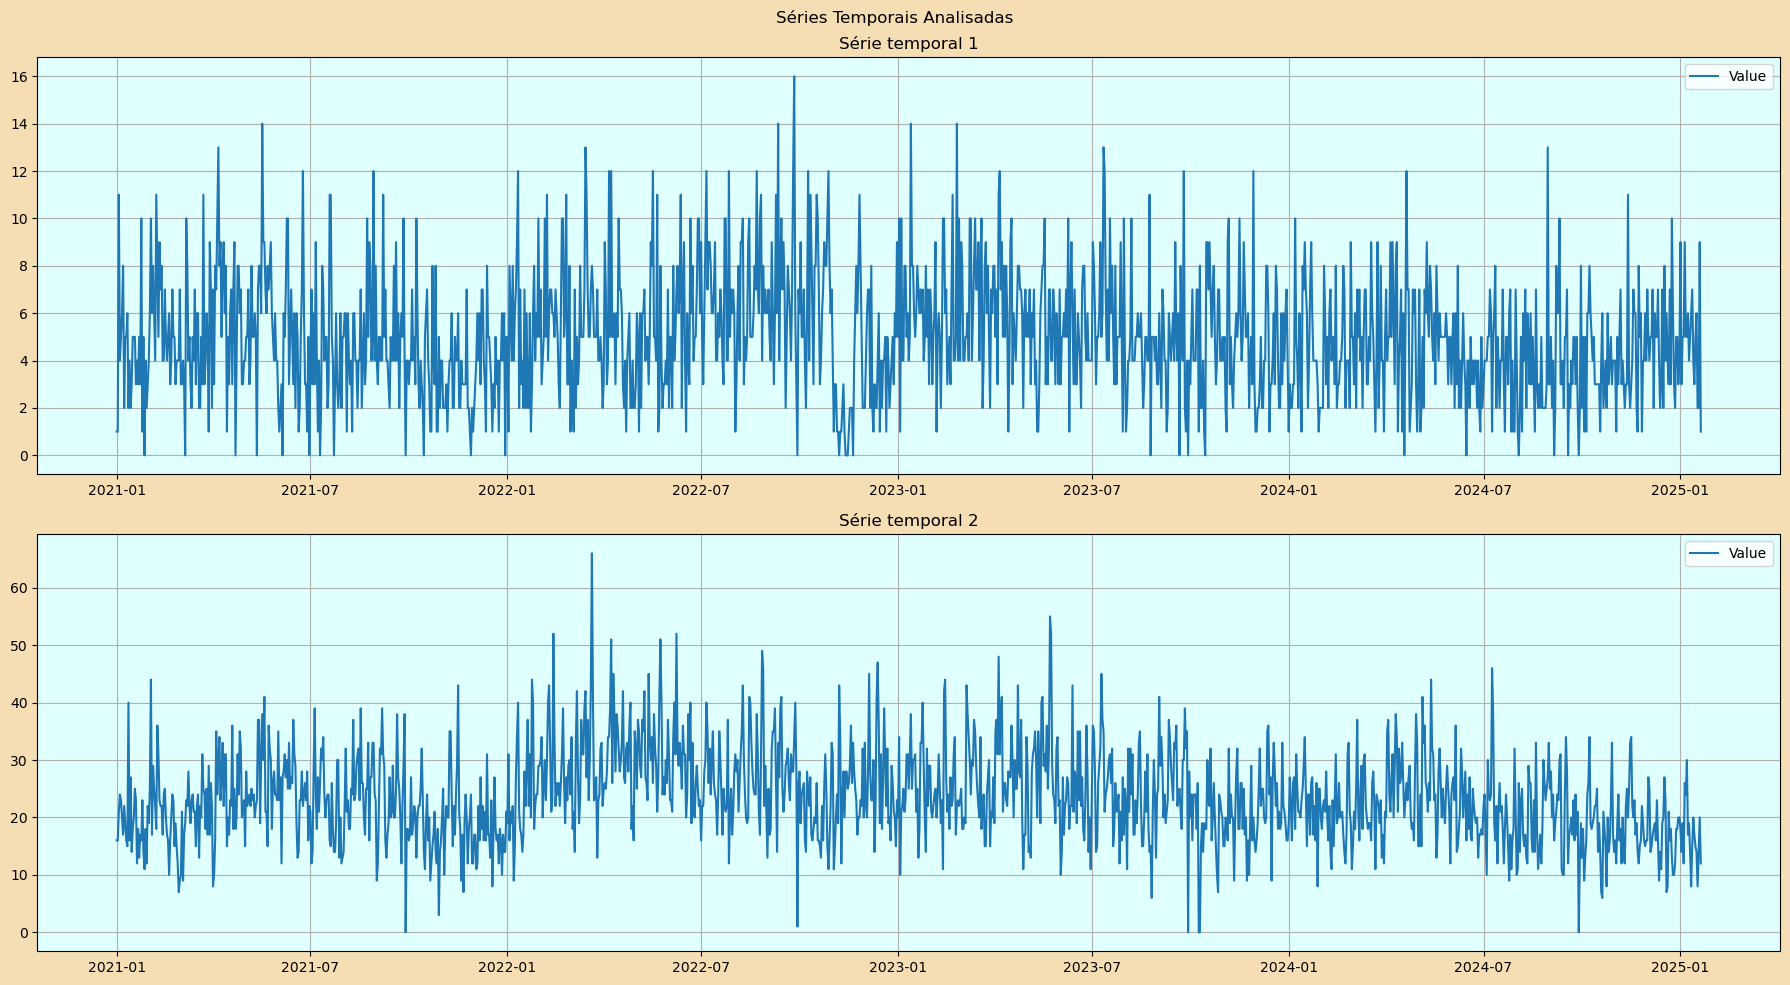

ADF Statistic: -9.905532
p-value: 0.000000
ADF Statistic: -4.055379
p-value: 0.001147


In [199]:
# série temporal em si é df_serie1 e df_serie4
fig,axes = plt.subplots(2,1,figsize=(18,10),facecolor='wheat')
sns.lineplot(df_serie1,ax=axes[0])
axes[0].set_title('Série temporal 1')
axes[0].set_facecolor('lightcyan')
axes[0].grid()
sns.lineplot(df_serie4,ax=axes[1])
axes[1].set_title('Série temporal 2')
axes[1].set_facecolor('lightcyan')
axes[1].grid()
plt.suptitle('Séries Temporais Analisadas')
plt.tight_layout()
plt.show()
perform_adf_test(df_serie1)
perform_adf_test(df_serie4)

Sendo assim, podemos provar que ambas são estacionárias. 
Podemos iniciar nosso modelo já deduzindo que será do modelo SARIMA(p,0,q)(P,0,Q)

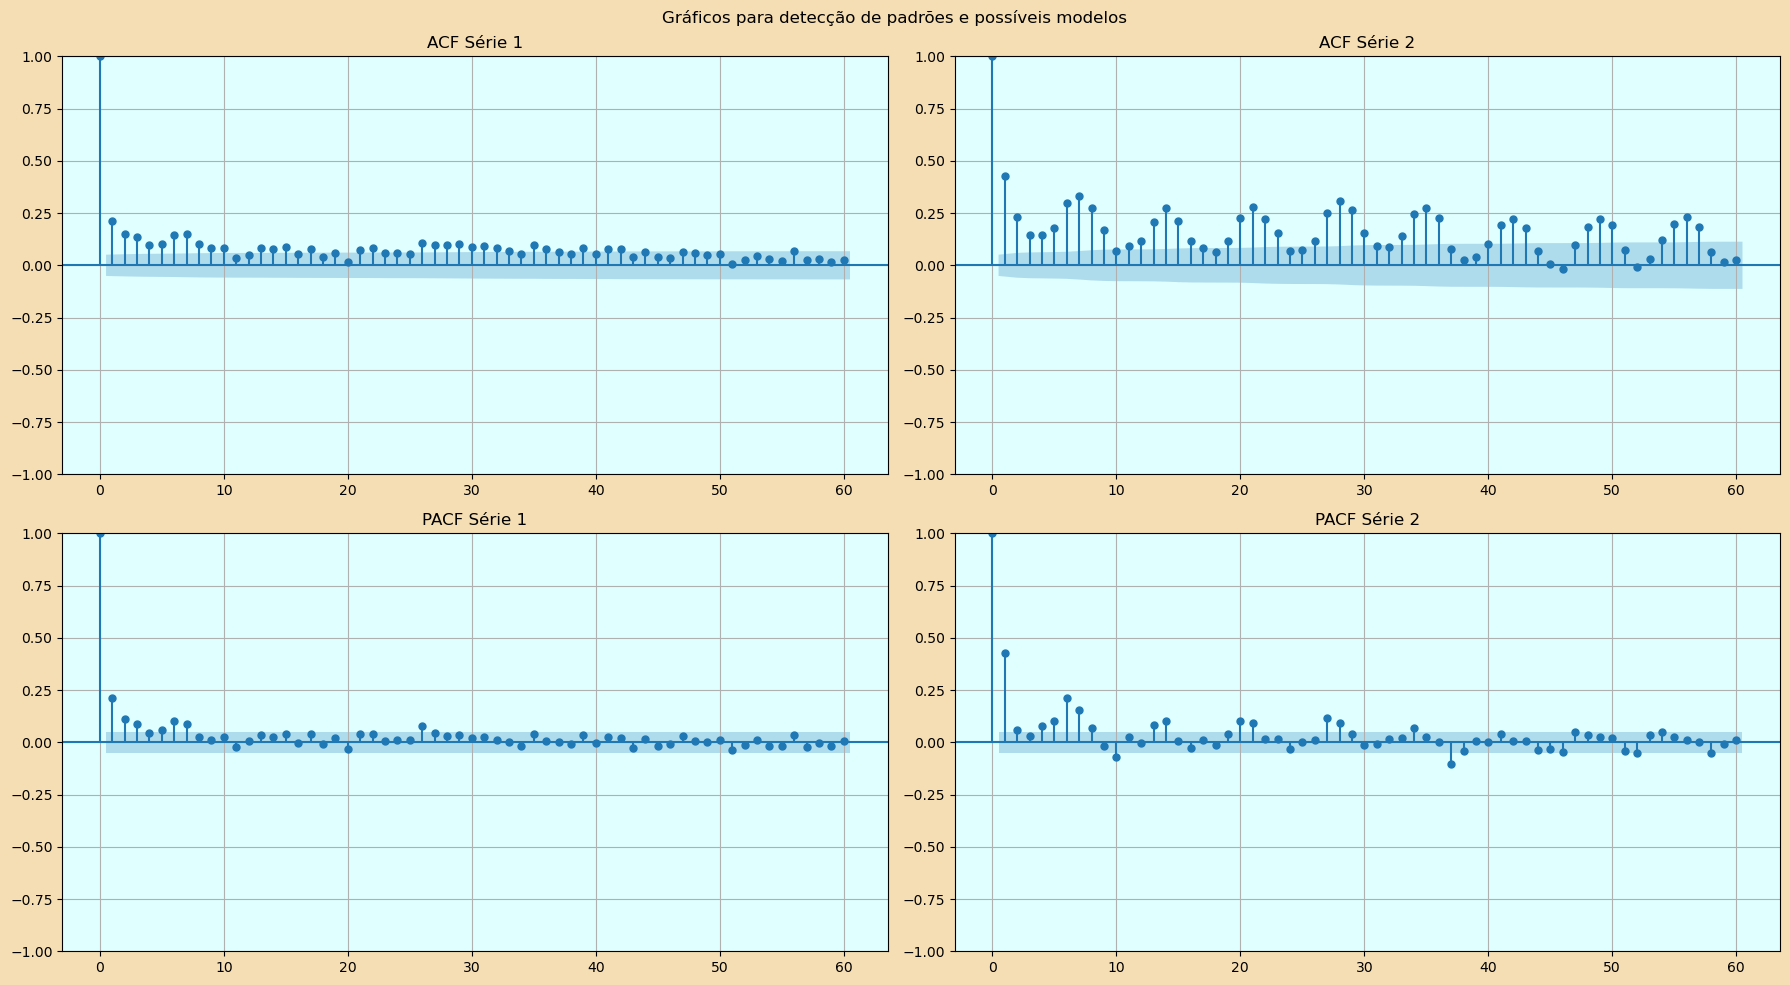

In [200]:
# Aplica PACF e ACF nas séries
fig,axes = plt.subplots(2,2,figsize=(18,10),facecolor='wheat')
acf1 = plot_acf(df_serie1,lags=60,ax=axes[0,0])
axes[0,0].set_title('ACF Série 1')
axes[0,0].set_facecolor('lightcyan')
axes[0,0].grid()
acf1 = plot_acf(df_serie4,lags=60,ax=axes[0,1])
axes[0,1].set_title('ACF Série 2')
axes[0,1].set_facecolor('lightcyan')
axes[0,1].grid()
pacf1 = plot_pacf(df_serie1,lags=60,ax=axes[1,0])
axes[1,0].set_title('PACF Série 1')
axes[1,0].set_facecolor('lightcyan')
axes[1,0].grid()
pacf4 = plot_pacf(df_serie4,lags=60,ax=axes[1,1])
axes[1,1].set_title('PACF Série 2')
axes[1,1].set_facecolor('lightcyan')
axes[1,1].grid()
plt.suptitle('Gráficos para detecção de padrões e possíveis modelos')
plt.tight_layout()
plt.show()

Analizando os gráficos de ACF e PACF para a série 1 e 2, podemos afirmar que os modelos serão da ordem de:
- Série 1: Uma vez que, o PACF tem um rápido drecréscimo após lag 3 e o ACF tem decrescimo gradual, a série 1 pode ser descrita como um ARIMA(p,0,q)
- Série 2: Uma vez que tanto PACF quanto ACF tem valores significativos após lag 1, além de uma clara componente sazonal, podemos afirmar que o modelo será um SARIMA (p,0,q)(P,0,Q)

Sendo assim, podemos perceber que

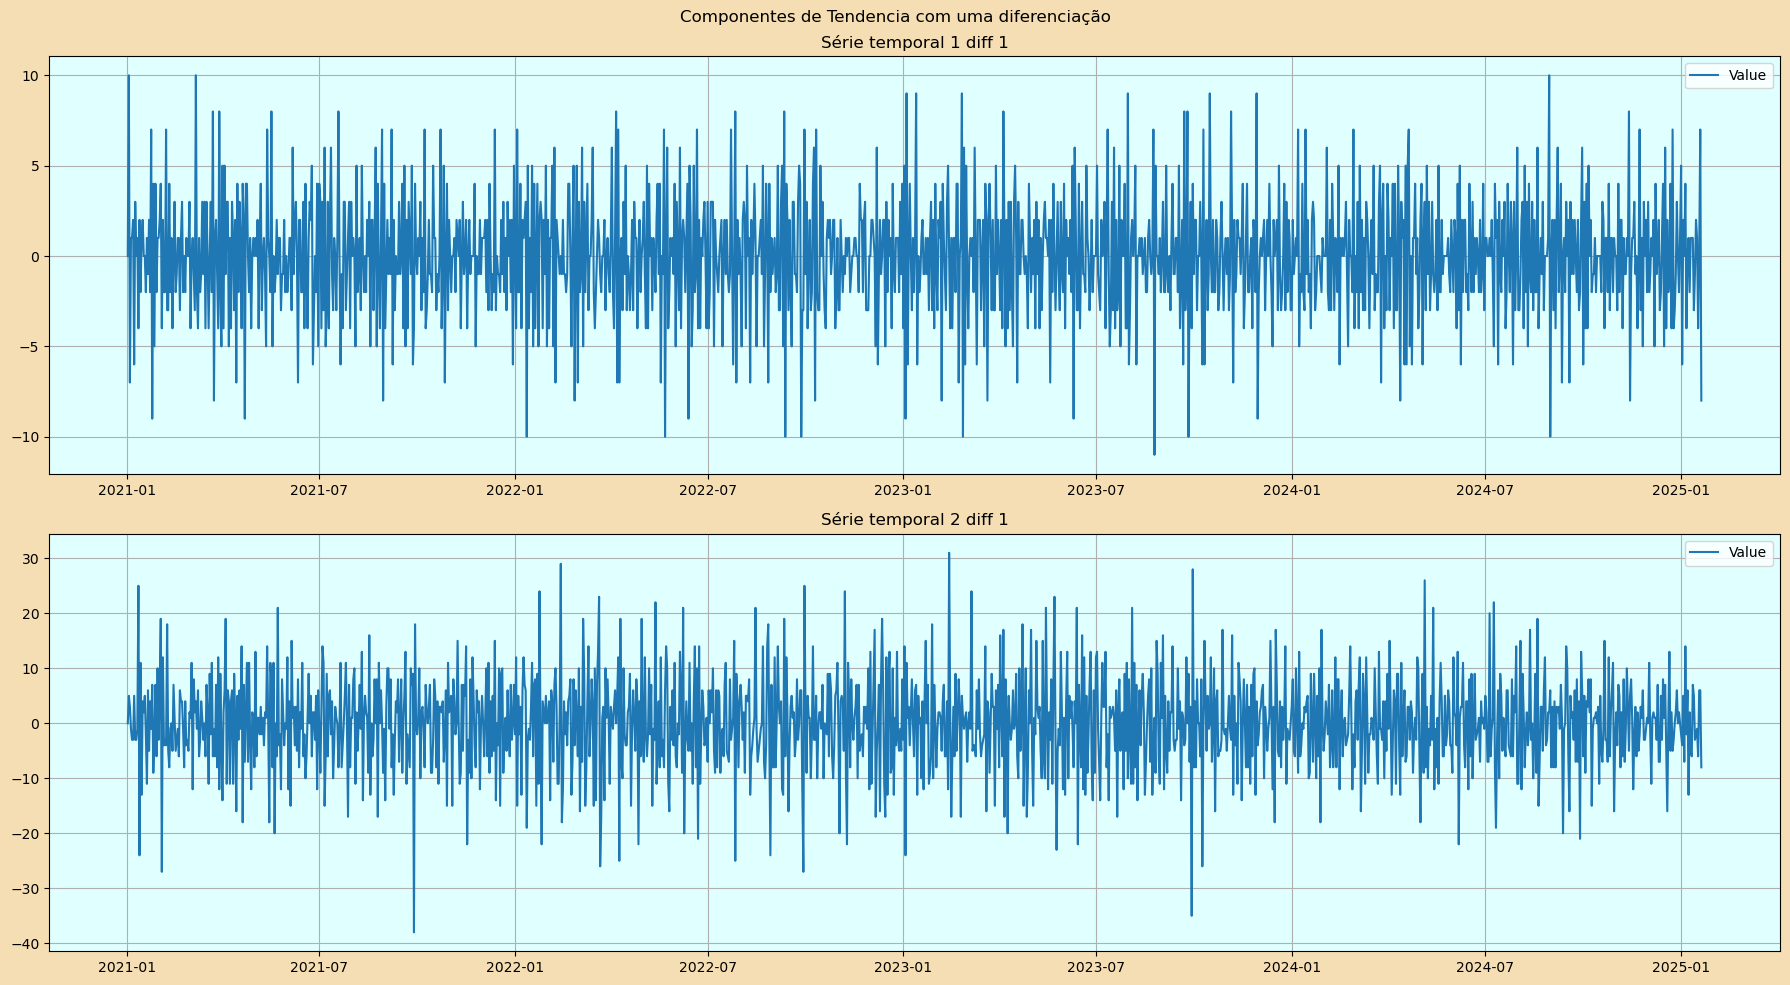

In [201]:
# Componente de tendência
fig,axes = plt.subplots(2,1,figsize=(18,10),facecolor='wheat')
sns.lineplot(df_serie1.diff(1).dropna(),ax=axes[0])
axes[0].set_title('Série temporal 1 diff 1')
axes[0].set_facecolor('lightcyan')
axes[0].grid()
sns.lineplot(df_serie4.diff(1).dropna(),ax=axes[1])
axes[1].set_title('Série temporal 2 diff 1')
axes[1].set_facecolor('lightcyan')
axes[1].grid()
plt.suptitle('Componentes de Tendencia com uma diferenciação')
plt.tight_layout()
plt.show()

Como esperado

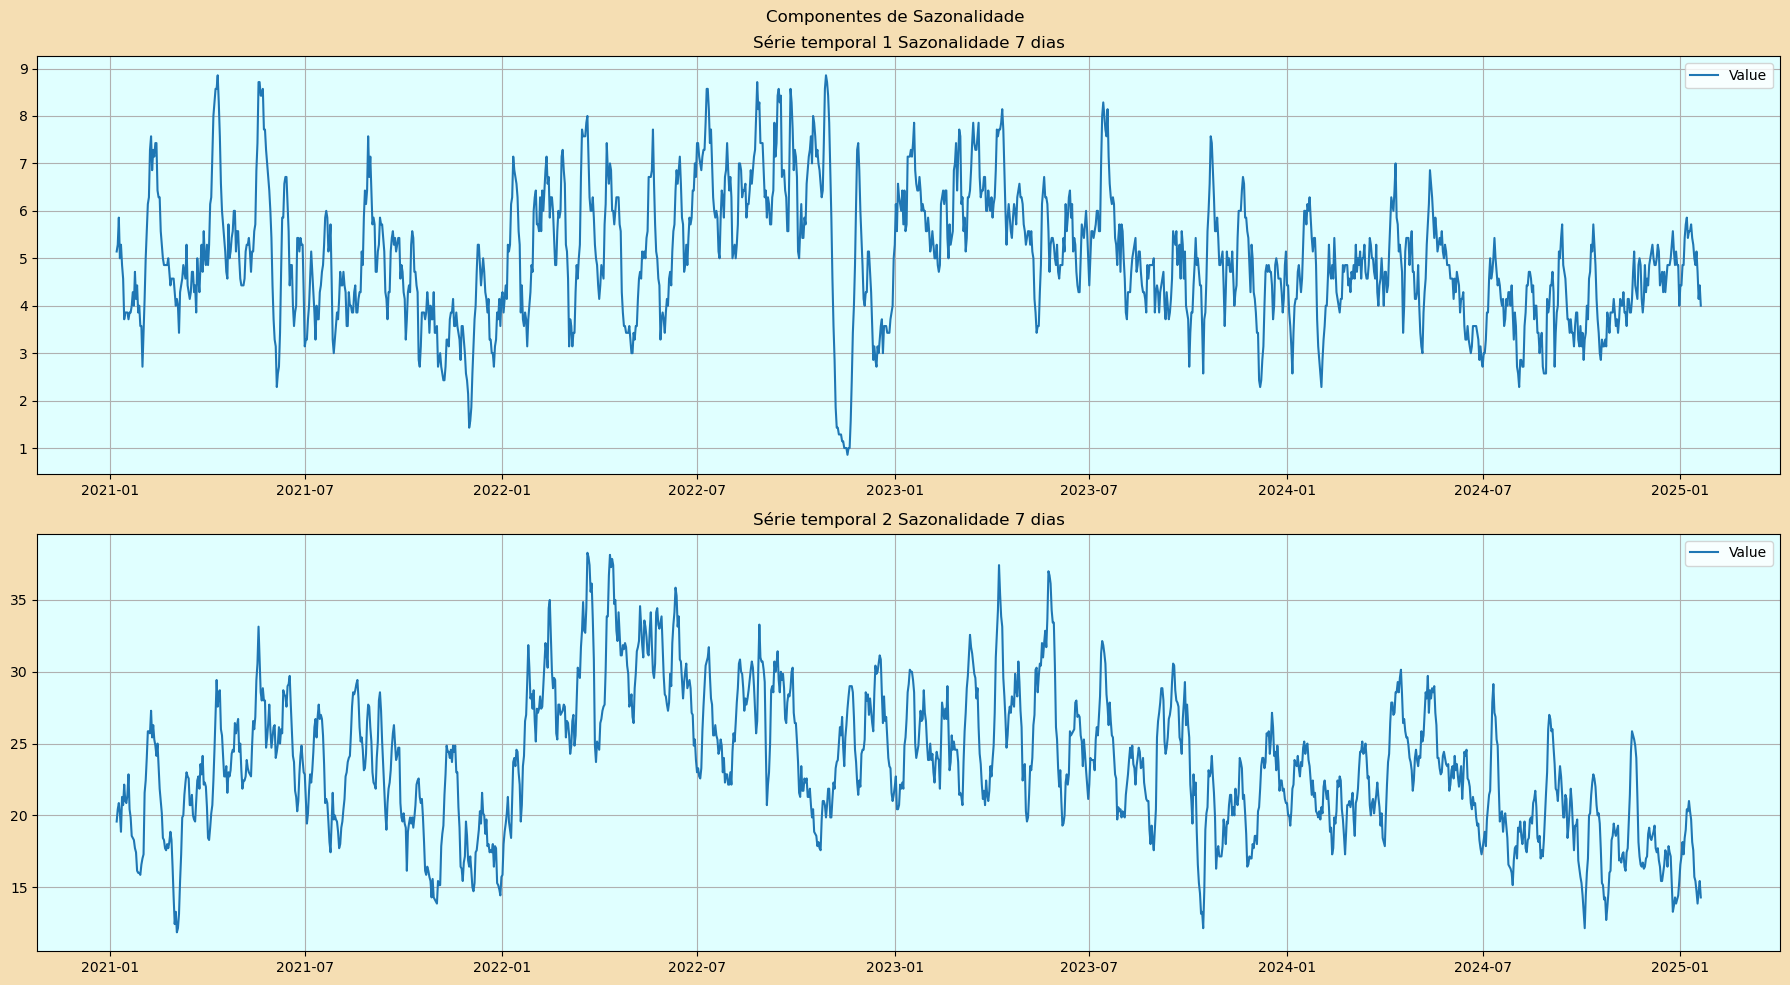

In [202]:
# Componente da sazonalidade (aqui obtive o número da rolling window após análise gráfica)
# Para a série 1 não temos sazonalidade (resultado da análise do PACF e do ACF)
# Para a série 2 podemos observar que existe sim sazonalidade em intervalos de 7 dias (análise do PACF e do ACF)
fig,axes = plt.subplots(2,1,figsize=(18,10),facecolor='wheat')
sns.lineplot(df_serie1.rolling(7).mean().dropna(),ax=axes[0])
axes[0].set_title('Série temporal 1 Sazonalidade 7 dias')
axes[0].set_facecolor('lightcyan')
axes[0].grid()
sns.lineplot(df_serie4.rolling(7).mean().dropna(),ax=axes[1])
axes[1].set_title('Série temporal 2 Sazonalidade 7 dias')
axes[1].set_facecolor('lightcyan')
axes[1].grid()
plt.suptitle('Componentes de Sazonalidade')
plt.tight_layout()
plt.show()

Podemos observar que na série 2, além da sazonalidade temos ciclos de 2 anos

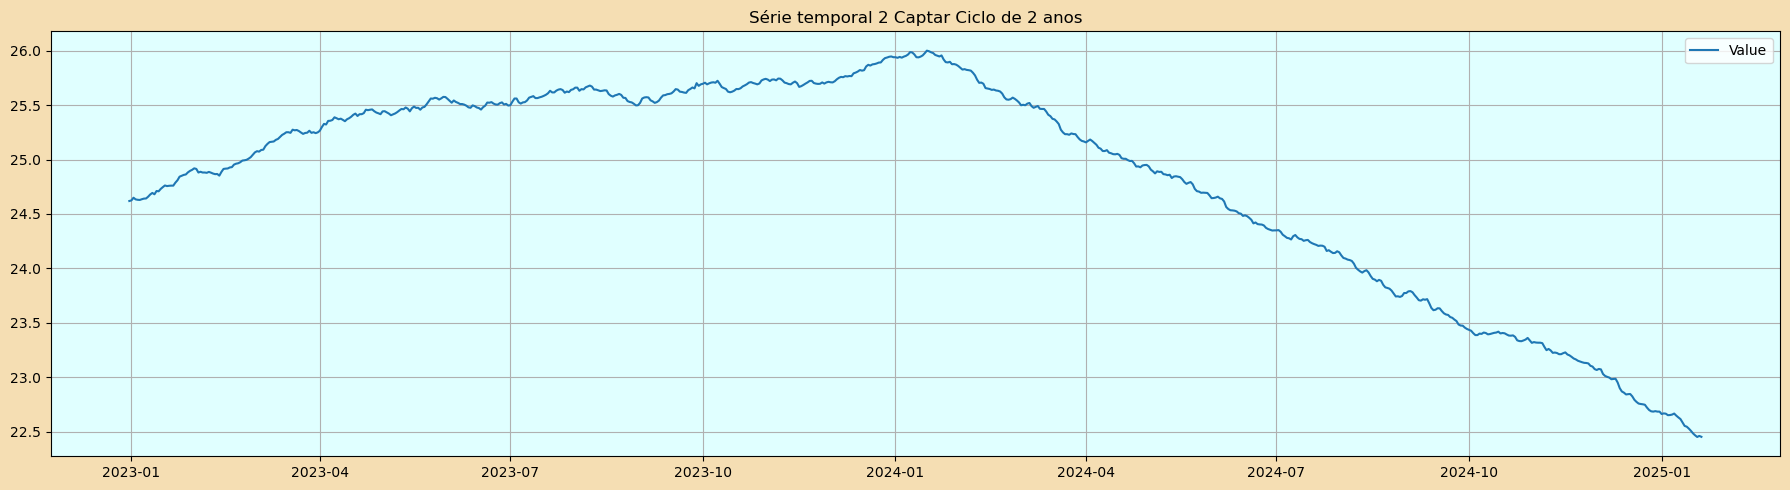

In [203]:
plt.figure(figsize=(18,5),facecolor='wheat')
sns.lineplot(df_serie4.rolling(730).mean().dropna())
plt.title('Série temporal 2 Captar Ciclo de 2 anos')
plt.gca().set_facecolor('lightcyan')
plt.grid()
plt.tight_layout()
plt.show()

In [204]:
#componente do ruído (subitraímos as expressões anteriores)
df_1_tend = df_serie1.diff(1).dropna()
df_4_tend = df_serie4.diff(1).dropna()
df_1_saz = 0
df_4_saz = df_serie4.rolling(7).mean().dropna()
df_serie1_ruido = df_serie1 - df_1_tend -df_1_saz
df_serie4_ruido = df_serie4 - df_4_tend -df_4_saz


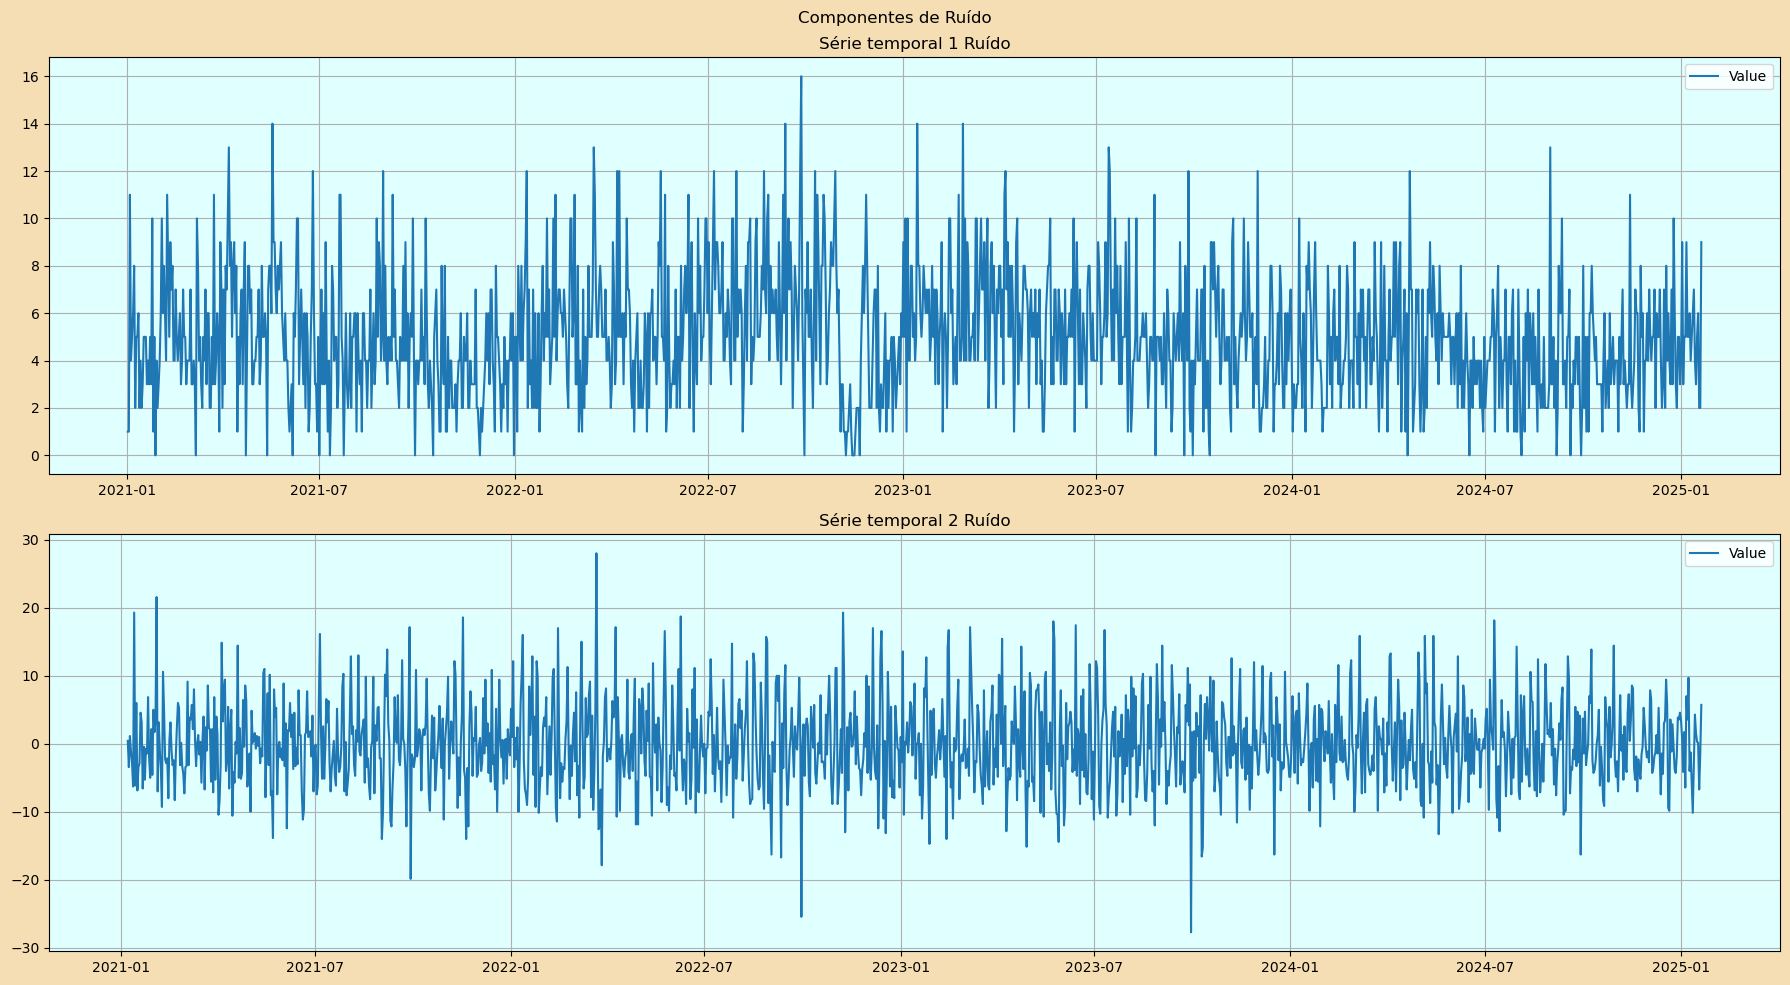

In [205]:
fig,axes = plt.subplots(2,1,figsize=(18,10),facecolor='wheat')
sns.lineplot(df_serie1_ruido.dropna(),ax=axes[0])
axes[0].set_title('Série temporal 1 Ruído')
axes[0].set_facecolor('lightcyan')
axes[0].grid()
sns.lineplot(df_serie4_ruido.dropna(),ax=axes[1])
axes[1].set_title('Série temporal 2 Ruído')
axes[1].set_facecolor('lightcyan')
axes[1].grid()
plt.suptitle('Componentes de Ruído')
plt.tight_layout()
plt.show()

In [206]:
perform_adf_test(df_serie1_ruido.dropna())
perform_adf_test(df_serie4_ruido.dropna())

ADF Statistic: -9.926644
p-value: 0.000000
ADF Statistic: -13.042571
p-value: 0.000000


Provado que o que restou e ruído

### Resposta exercício 1

- Características da Série Temporal 1:
    - Série estacionária 
    - Sem componente sazonal 
    - Apresenta um comportamento de uma série de modelo de média móvel MA(q)
- Características da Série Temporal 2:
    - Série estacionária
    - Apresenta um componente sazonal 
    - Presença de possível ciclo de 2 anos
    - Apresenta um comportamento de uma série de modelo SARIMA(s,0,q)(S,0,Q)

## Tipo de modelo clássico

Qual tipo de modelo melhor descreve a série de tempo? Multiplicativo ou aditivo?

<Figure size 1200x800 with 0 Axes>

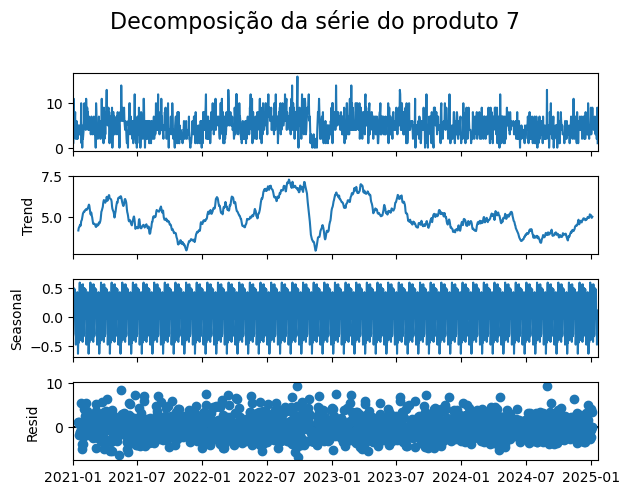

<Figure size 1200x800 with 0 Axes>

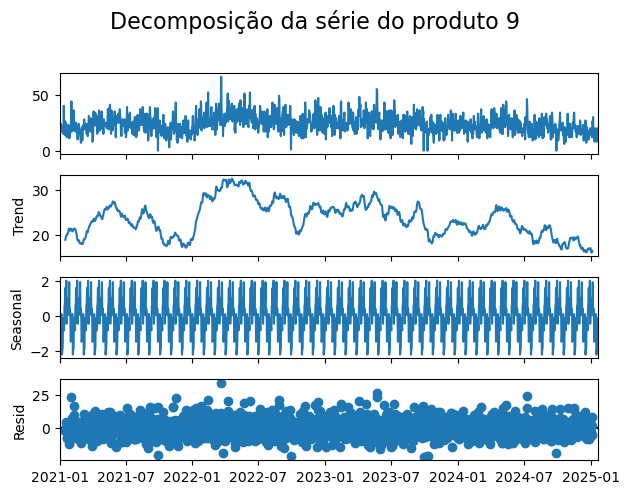

In [207]:
# Decomposição aditiva
plt.figure(figsize=(12, 8))  # Ajustando o tamanho da figura
result_additive = seasonal_decompose(df_serie1, model='additive',period=30)
result_additive.plot().suptitle('Decomposição da série do produto 7', fontsize=16, y=1.02)  # Ajuste para título
plt.tight_layout()
plt.show()

# Decomposição multiplicativa
plt.figure(figsize=(12, 8))  # Ajustando o tamanho da figura
result_multiplicative = seasonal_decompose(df_serie4, model='additive',period=30)
result_multiplicative.plot().suptitle('Decomposição da série do produto 9', fontsize=16, y=1.02)  # Ajuste para título
plt.tight_layout()
plt.show()

### Resposta Exercício 2
- Uma vez que a série possuí alguns caso com valor 0, o modelo multiplicativo não pôde ser gerado porém podemos mesmo assim afirmar que as nossas séries sao séries do modelo aditivo pois:
    - A variância e o desvio padrão dos dados é constante em nossa time-series (isso pode ser observado tanto visualmente quanto pelo teste do Augmented Dickey Fuller)
    - Ao rodar o modelo aditivo, podemos observar as componentes que analisamos anteriormente na base


## ARIMA

Vamos realizar a previsão utilizando esse modelo

Dividindo os datasets entre treino e teste:

In [208]:
data_limite_1 = df_serie1.index[-40]  # Pega a data do 40º índice a partir do final
df_1_train = df_serie1[df_serie1.index < data_limite_1]
df_1_test = df_serie1[df_serie1.index >= data_limite_1]

data_limite_2 = df_serie4.index[-40] 
df_2_train = df_serie4[df_serie4.index < data_limite_2]
df_2_test = df_serie4[df_serie4.index >= data_limite_2]

Inicializando os modelos

In [209]:
modelo1 = ARIMA(df_1_train,order=(3,0,9))
modelo1_fit = modelo1.fit()
print(modelo1_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 1441
Model:                 ARIMA(3, 0, 9)   Log Likelihood               -3365.183
Date:                Sun, 29 Sep 2024   AIC                           6758.366
Time:                        12:23:12   BIC                           6832.189
Sample:                    01-01-2021   HQIC                          6785.923
                         - 12-11-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0037      0.266     18.837      0.000       4.483       5.524
ar.L1         -0.1425      0.347     -0.411      0.681      -0.823       0.538
ar.L2          0.6413      0.224      2.860      0.0

c:\Users\engca\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [210]:
modelo2 = ARIMA(df_2_train,order=(6,0,9))
modelo2_fit = modelo2.fit()
print(modelo2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 1441
Model:                 ARIMA(6, 0, 9)   Log Likelihood               -4782.937
Date:                Sun, 29 Sep 2024   AIC                           9599.874
Time:                        12:23:17   BIC                           9689.516
Sample:                    01-01-2021   HQIC                          9633.336
                         - 12-11-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.7390      1.427     16.636      0.000      20.942      26.536
ar.L1          0.3268      0.068      4.800      0.000       0.193       0.460
ar.L2          0.1364      0.085      1.597      0.1

c:\Users\engca\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [211]:
forecast1 = modelo1_fit.forecast(len(df_1_test))
forecast2 = modelo2_fit.forecast(len(df_2_test))

<Axes: >

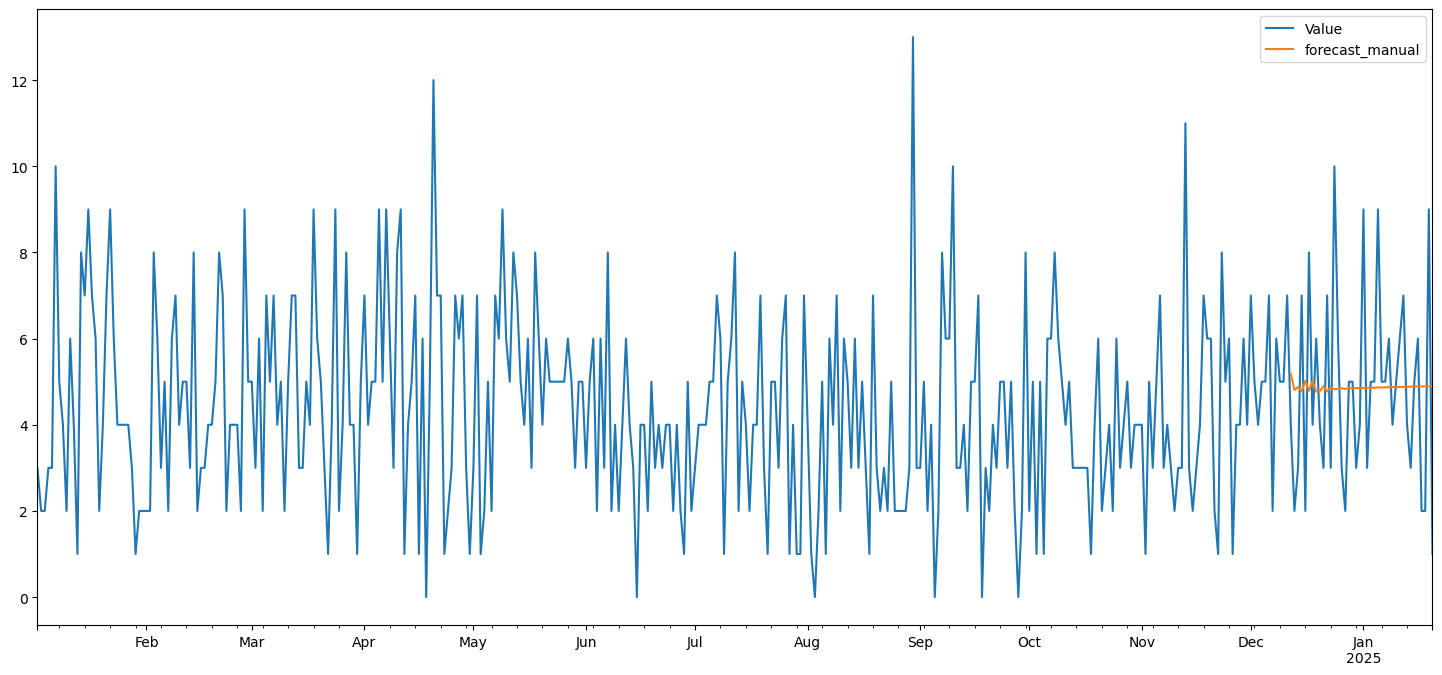

In [212]:
df_serie1['forecast_manual'] = [None]*len(df_1_train) + list(forecast1)
df_serie1[df_serie1.index > '2024-01-01'].plot(figsize=(18,8))

<Axes: >

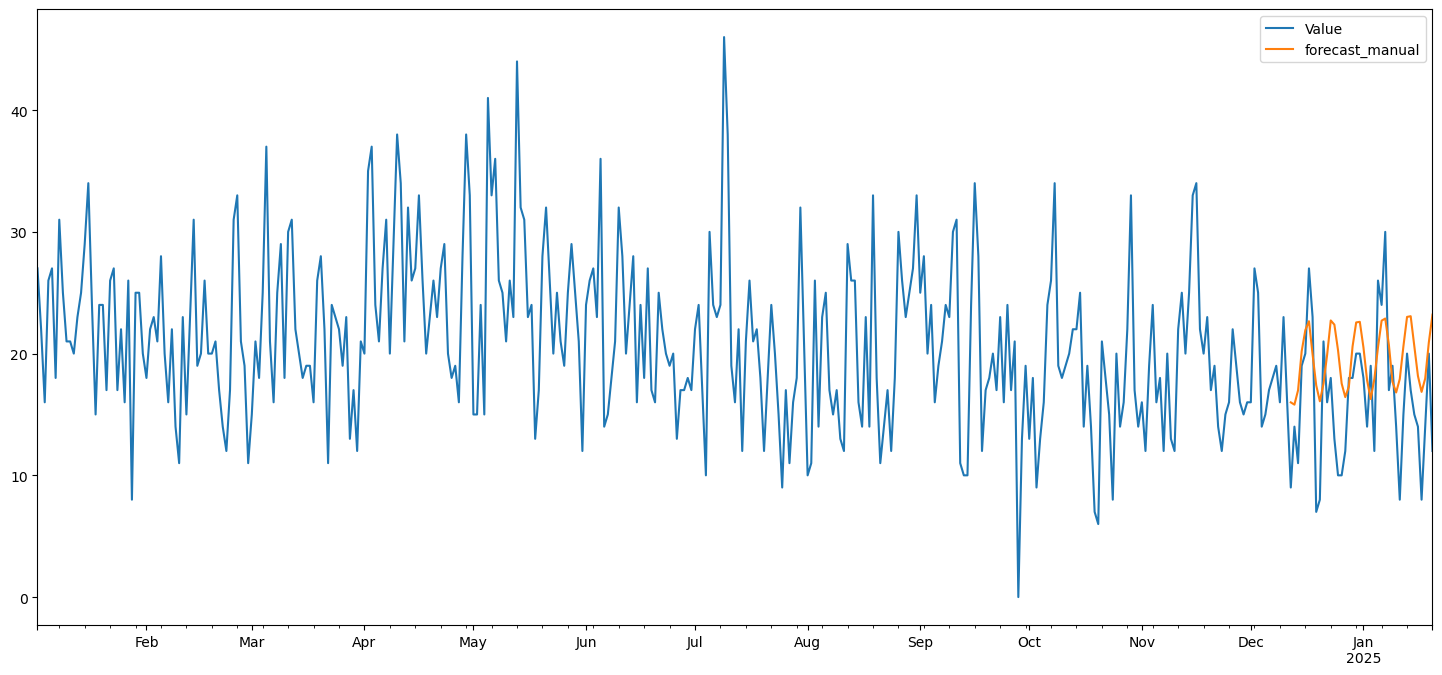

In [213]:
df_serie4['forecast_manual'] = [None]*len(df_2_train) + list(forecast2)
df_serie4[df_serie4.index > '2024-01-01'].plot(figsize=(18,8))

## Métricas de erro

In [214]:
mae_1 = mean_absolute_error(df_1_test, forecast1)
mae_2 = mean_absolute_error(df_2_test, forecast2)
rmse_1 = root_mean_squared_error(df_1_test, forecast1)
rmse_2 = root_mean_squared_error(df_2_test, forecast2)
mse_1 = mean_squared_error(df_1_test, forecast1)
mse_2 = mean_squared_error(df_2_test, forecast2)

print(f"RMSE 1: {rmse_1}")
print(f"RMSE 2: {rmse_2}")
print(f"MAE 1: {mae_1}")
print(f"MAE 2: {mae_2}")
print(f"MSE 1: {mse_1}")
print(f"MSE 2: {mse_2}")

RMSE 1: 2.2140747131018363
RMSE 2: 5.587582752338052
MAE 1: 1.7796700384681572
MAE 2: 4.799421800582222
MSE 1: 4.902126835196979
MSE 2: 31.22108101422568


## Holt-Winter

## Regressão linear multivariada

## Outros modelos de regressão